# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [73]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   int     1206 non-null   int64 
 1   ac      1206 non-null   int64 
 2   hp      1206 non-null   int64 
 3   str     1206 non-null   int64 
 4   con     1206 non-null   int64 
 5   cha     1206 non-null   int64 
 6   dex     1206 non-null   int64 
 7   wis     1206 non-null   int64 
 8   book    1206 non-null   object
 9   level   1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [75]:
df.head()

,int,ac,hp,str,con,cha,dex,wis,book,level
0,1,29,215,7,5,1,2,2,Pathfinder Bestiary,10
1,-4,28,220,9,5,1,0,2,Pathfinder Bestiary,10
2,-4,25,175,7,6,-2,3,3,Pathfinder Bestiary,8
3,6,41,315,7,5,6,4,5,Pathfinder Bestiary,17
4,-1,16,20,-5,1,1,3,1,Pathfinder Bestiary,1


###### Level

In [76]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [77]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [78]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


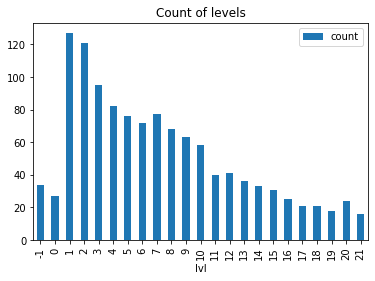

In [79]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [80]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [81]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [82]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [83]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [84]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [85]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [87]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [88]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [89]:
from training.results import plot_mae_by_level

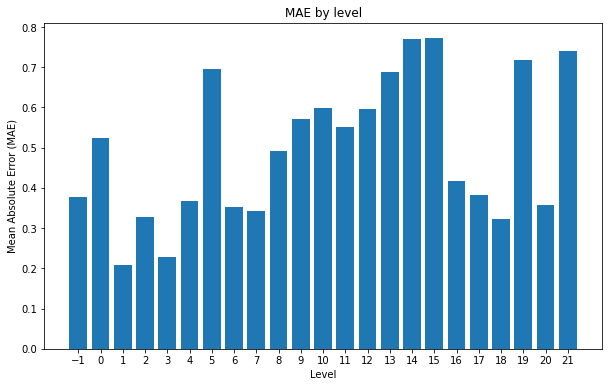

In [90]:
plot_mae_by_level(y_test, y_pred_test)

In [91]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



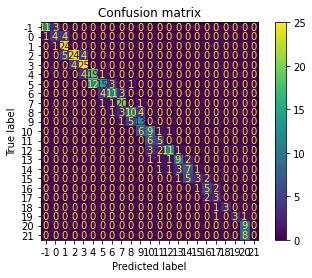

In [92]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [93]:
from training.results import assess_regression_model

In [94]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:23:06,459] A new study created in memory with name: no-name-982ccbf6-cc0c-4900-8206-195a730ca1ab

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0496004



feature_fraction, val_score: 0.231230:  14%|######4                                      | 1/7 [00:00<00:05,  1.20it/s][I 2023-11-03 20:23:07,301] Trial 0 finished with value: 0.23122967944103578 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.23122967944103578.

feature_fraction, val_score: 0.231230:  14%|######4                                      | 1/7 [00:00<00:05,  1.20it/s]

Early stopping, best iteration is:
[174]	cv_agg's l2: 0.23123 + 0.0496955
[100]	cv_agg's l2: 0.230809 + 0.0334825
[200]	cv_agg's l2: 0.225128 + 0.0356201
[300]	cv_agg's l2: 0.224722 + 0.0363901



feature_fraction, val_score: 0.224406:  29%|############8                                | 2/7 [00:02<00:06,  1.28s/it][I 2023-11-03 20:23:08,900] Trial 1 finished with value: 0.2244056787944811 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.2244056787944811.

feature_fraction, val_score: 0.224406:  29%|############8                                | 2/7 [00:02<00:06,  1.28s/it]

[400]	cv_agg's l2: 0.227075 + 0.0374359
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.224406 + 0.0365606
[100]	cv_agg's l2: 0.230809 + 0.0334825
[200]	cv_agg's l2: 0.225128 + 0.0356201
[300]	cv_agg's l2: 0.224722 + 0.0363901



feature_fraction, val_score: 0.224406:  43%|###################2                         | 3/7 [00:04<00:05,  1.50s/it][I 2023-11-03 20:23:10,650] Trial 2 finished with value: 0.2244056787944811 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.2244056787944811.

feature_fraction, val_score: 0.224406:  43%|###################2                         | 3/7 [00:04<00:05,  1.50s/it]

[400]	cv_agg's l2: 0.227075 + 0.0374359
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.224406 + 0.0365606
[100]	cv_agg's l2: 0.230238 + 0.0513614
[200]	cv_agg's l2: 0.228089 + 0.0489182
[300]	cv_agg's l2: 0.23088 + 0.049828



feature_fraction, val_score: 0.224406:  57%|#########################7                   | 4/7 [00:06<00:05,  1.67s/it][I 2023-11-03 20:23:12,583] Trial 3 finished with value: 0.23089876301679907 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.2244056787944811.

feature_fraction, val_score: 0.224406:  57%|#########################7                   | 4/7 [00:06<00:05,  1.67s/it]

[400]	cv_agg's l2: 0.23298 + 0.0502458
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.224406 + 0.0365606
[100]	cv_agg's l2: 0.250527 + 0.0353293
[200]	cv_agg's l2: 0.235391 + 0.0367703
[300]	cv_agg's l2: 0.231816 + 0.0381611



feature_fraction, val_score: 0.224406:  71%|################################1            | 5/7 [00:08<00:03,  1.91s/it][I 2023-11-03 20:23:14,932] Trial 4 finished with value: 0.23159684358796864 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.2244056787944811.

feature_fraction, val_score: 0.224406:  71%|################################1            | 5/7 [00:08<00:03,  1.91s/it]

[400]	cv_agg's l2: 0.230325 + 0.0373731
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.224406 + 0.0365606
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486



feature_fraction, val_score: 0.223434:  86%|######################################5      | 6/7 [00:11<00:02,  2.33s/it][I 2023-11-03 20:23:18,080] Trial 5 finished with value: 0.2234341067699574 and parameters: {'feature_fraction': 0.6}. Best is trial 5 with value: 0.2234341067699574.

feature_fraction, val_score: 0.223434:  86%|######################################5      | 6/7 [00:11<00:02,  2.33s/it]

[500]	cv_agg's l2: 0.224286 + 0.039282
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.223434 + 0.0384867
[100]	cv_agg's l2: 0.391094 + 0.0843401
[200]	cv_agg's l2: 0.33907 + 0.0785272
[300]	cv_agg's l2: 0.318471 + 0.0726064
[400]	cv_agg's l2: 0.309643 + 0.0694415



feature_fraction, val_score: 0.223434: 100%|#############################################| 7/7 [00:15<00:00,  2.16s/it]


[500]	cv_agg's l2: 0.305555 + 0.0681968
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.223434 + 0.0384867



num_leaves, val_score: 0.223434:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.237214 + 0.0354401
[200]	cv_agg's l2: 0.225348 + 0.0354551
[300]	cv_agg's l2: 0.221085 + 0.0350189
[400]	cv_agg's l2: 0.218607 + 0.0343749
[500]	cv_agg's l2: 0.217594 + 0.0352704



num_leaves, val_score: 0.217341:   5%|##5                                               | 1/20 [00:02<00:38,  2.01s/it][I 2023-11-03 20:23:23,608] Trial 7 finished with value: 0.2173413542444794 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:   5%|##5                                               | 1/20 [00:02<00:38,  2.01s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  10%|#####                                             | 2/20 [00:05<00:54,  3.05s/it][I 2023-11-03 20:23:27,380] Trial 8 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  10%|#####                                             | 2/20 [00:05<00:54,  3.05s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  15%|#######5                                          | 3/20 [00:09<00:56,  3.33s/it][I 2023-11-03 20:23:31,056] Trial 9 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 193}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  15%|#######5                                          | 3/20 [00:09<00:56,  3.33s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.237214 + 0.0354401
[200]	cv_agg's l2: 0.225348 + 0.0354551
[300]	cv_agg's l2: 0.221085 + 0.0350189
[400]	cv_agg's l2: 0.218607 + 0.0343749
[500]	cv_agg's l2: 0.217594 + 0.0352704



num_leaves, val_score: 0.217341:  20%|##########                                        | 4/20 [00:11<00:44,  2.81s/it][I 2023-11-03 20:23:33,059] Trial 10 finished with value: 0.2173413542444794 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  20%|##########                                        | 4/20 [00:11<00:44,  2.81s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.256045 + 0.0445748
[200]	cv_agg's l2: 0.239589 + 0.0430801
[300]	cv_agg's l2: 0.231246 + 0.0375898
[400]	cv_agg's l2: 0.226243 + 0.033987


[500]	cv_agg's l2: 0.222487 + 0.0329208
Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496


num_leaves, val_score: 0.217341:  25%|############5                                     | 5/20 [00:12<00:33,  2.23s/it][I 2023-11-03 20:23:34,262] Trial 11 finished with value: 0.22309598289505814 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  25%|############5                                     | 5/20 [00:12<00:33,  2.23s/it]

[100]	cv_agg's l2: 0.237362 + 0.0379045
[200]	cv_agg's l2: 0.225929 + 0.0395273
[300]	cv_agg's l2: 0.223431 + 0.0386523
[400]	cv_agg's l2: 0.223497 + 0.0395203
[500]	cv_agg's l2: 0.223973 + 0.0393018



num_leaves, val_score: 0.217341:  30%|###############                                   | 6/20 [00:15<00:35,  2.52s/it][I 2023-11-03 20:23:37,345] Trial 12 finished with value: 0.22395062744632055 and parameters: {'num_leaves': 22}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  30%|###############                                   | 6/20 [00:15<00:35,  2.52s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  35%|#################5                                | 7/20 [00:19<00:37,  2.90s/it][I 2023-11-03 20:23:41,028] Trial 13 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 79}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  35%|#################5                                | 7/20 [00:19<00:37,  2.90s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  40%|####################                              | 8/20 [00:22<00:36,  3.05s/it][I 2023-11-03 20:23:44,386] Trial 14 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 87}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  40%|####################                              | 8/20 [00:22<00:36,  3.05s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  45%|######################5                           | 9/20 [00:26<00:34,  3.15s/it][I 2023-11-03 20:23:47,751] Trial 15 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 60}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  45%|######################5                           | 9/20 [00:26<00:34,  3.15s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  50%|########################5                        | 10/20 [00:29<00:32,  3.29s/it][I 2023-11-03 20:23:51,364] Trial 16 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  50%|########################5                        | 10/20 [00:29<00:32,  3.29s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.256045 + 0.0445748
[200]	cv_agg's l2: 0.239589 + 0.0430801
[300]	cv_agg's l2: 0.231246 + 0.0375898
[400]	cv_agg's l2: 0.226243 + 0.033987
[500]	cv_agg's l2: 0.222487 + 0.0329208



num_leaves, val_score: 0.217341:  55%|##########################9                      | 11/20 [00:31<00:24,  2.69s/it][I 2023-11-03 20:23:52,701] Trial 17 finished with value: 0.22309598289505814 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  55%|##########################9                      | 11/20 [00:31<00:24,  2.69s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  60%|#############################4                   | 12/20 [00:35<00:25,  3.13s/it][I 2023-11-03 20:23:56,845] Trial 18 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 62}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  60%|#############################4                   | 12/20 [00:35<00:25,  3.13s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  65%|###############################8                 | 13/20 [00:38<00:22,  3.21s/it][I 2023-11-03 20:24:00,241] Trial 19 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 132}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  65%|###############################8                 | 13/20 [00:38<00:22,  3.21s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  70%|##################################3              | 14/20 [00:42<00:19,  3.30s/it][I 2023-11-03 20:24:03,734] Trial 20 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 36}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  70%|##################################3              | 14/20 [00:42<00:19,  3.30s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.253647 + 0.0394103
[200]	cv_agg's l2: 0.238063 + 0.0365059
[300]	cv_agg's l2: 0.230473 + 0.0318501
[400]	cv_agg's l2: 0.22591 + 0.0305855
[500]	cv_agg's l2: 0.223022 + 0.0293351



num_leaves, val_score: 0.217341:  75%|####################################7            | 15/20 [00:43<00:13,  2.71s/it][I 2023-11-03 20:24:05,081] Trial 21 finished with value: 0.22360829559241538 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  75%|####################################7            | 15/20 [00:43<00:13,  2.71s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  80%|#######################################2         | 16/20 [00:47<00:12,  3.04s/it][I 2023-11-03 20:24:08,877] Trial 22 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 253}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  80%|#######################################2         | 16/20 [00:47<00:12,  3.04s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  85%|#########################################6       | 17/20 [00:50<00:09,  3.16s/it][I 2023-11-03 20:24:12,338] Trial 23 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  85%|#########################################6       | 17/20 [00:50<00:09,  3.16s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.341903 + 0.0422746
[200]	cv_agg's l2: 0.30476 + 0.0429078
[300]	cv_agg's l2: 0.295428 + 0.0435111
[400]	cv_agg's l2: 0.292388 + 0.0432002
[500]	cv_agg's l2: 0.290717 + 0.0434717



num_leaves, val_score: 0.217341:  90%|############################################1    | 18/20 [00:51<00:04,  2.46s/it][I 2023-11-03 20:24:13,164] Trial 24 finished with value: 0.29101252727580934 and parameters: {'num_leaves': 2}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  90%|############################################1    | 18/20 [00:51<00:04,  2.46s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341:  95%|##############################################5  | 19/20 [00:55<00:02,  2.76s/it][I 2023-11-03 20:24:16,619] Trial 25 finished with value: 0.2241019064830066 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.2173413542444794.

num_leaves, val_score: 0.217341:  95%|##############################################5  | 19/20 [00:55<00:02,  2.76s/it]

Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496
[100]	cv_agg's l2: 0.23794 + 0.0355051
[200]	cv_agg's l2: 0.226243 + 0.0382786
[300]	cv_agg's l2: 0.22434 + 0.038315
[400]	cv_agg's l2: 0.223509 + 0.038486
[500]	cv_agg's l2: 0.224286 + 0.039282



num_leaves, val_score: 0.217341: 100%|#################################################| 20/20 [00:58<00:00,  2.92s/it]


Early stopping, best iteration is:
[486]	cv_agg's l2: 0.217341 + 0.03496



bagging, val_score: 0.217341:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.24294 + 0.0387454
[200]	cv_agg's l2: 0.227196 + 0.0394291
[300]	cv_agg's l2: 0.22131 + 0.0377749
[400]	cv_agg's l2: 0.217776 + 0.0373919
[500]	cv_agg's l2: 0.217234 + 0.038746
[600]	cv_agg's l2: 0.215592 + 0.0382357



bagging, val_score: 0.214587:  10%|#####3                                               | 1/10 [00:02<00:24,  2.70s/it][I 2023-11-03 20:24:22,768] Trial 27 finished with value: 0.2145869720257231 and parameters: {'bagging_fraction': 0.8861802345943328, 'bagging_freq': 5}. Best is trial 27 with value: 0.2145869720257231.

bagging, val_score: 0.214587:  10%|#####3                                               | 1/10 [00:02<00:24,  2.70s/it]

Early stopping, best iteration is:
[561]	cv_agg's l2: 0.214587 + 0.0380092
[100]	cv_agg's l2: 0.245809 + 0.0431544
[200]	cv_agg's l2: 0.22883 + 0.0420408
[300]	cv_agg's l2: 0.222459 + 0.0397698
[400]	cv_agg's l2: 0.217297 + 0.0377083
[500]	cv_agg's l2: 0.215996 + 0.0384728
[600]	cv_agg's l2: 0.215849 + 0.0381329



bagging, val_score: 0.214587:  20%|##########6                                          | 2/10 [00:05<00:20,  2.60s/it][I 2023-11-03 20:24:25,290] Trial 28 finished with value: 0.2155106757241903 and parameters: {'bagging_fraction': 0.910507589074558, 'bagging_freq': 5}. Best is trial 27 with value: 0.2145869720257231.

bagging, val_score: 0.214587:  20%|##########6                                          | 2/10 [00:05<00:20,  2.60s/it]

Early stopping, best iteration is:
[561]	cv_agg's l2: 0.214587 + 0.0380092
[100]	cv_agg's l2: 0.244463 + 0.0442653
[200]	cv_agg's l2: 0.229097 + 0.0429497
[300]	cv_agg's l2: 0.223265 + 0.0425788
[400]	cv_agg's l2: 0.21864 + 0.0399969
[500]	cv_agg's l2: 0.217733 + 0.0407372
[600]	cv_agg's l2: 0.217604 + 0.0397845



bagging, val_score: 0.214587:  30%|###############9                                     | 3/10 [00:08<00:18,  2.69s/it][I 2023-11-03 20:24:28,096] Trial 29 finished with value: 0.21695571187802692 and parameters: {'bagging_fraction': 0.920692445742629, 'bagging_freq': 5}. Best is trial 27 with value: 0.2145869720257231.

bagging, val_score: 0.214587:  30%|###############9                                     | 3/10 [00:08<00:18,  2.69s/it]

Early stopping, best iteration is:
[561]	cv_agg's l2: 0.214587 + 0.0380092
[100]	cv_agg's l2: 0.241808 + 0.04135
[200]	cv_agg's l2: 0.227067 + 0.037774
[300]	cv_agg's l2: 0.221665 + 0.037646
[400]	cv_agg's l2: 0.21899 + 0.0367593
[500]	cv_agg's l2: 0.219083 + 0.0374329
[600]	cv_agg's l2: 0.219078 + 0.0369129



bagging, val_score: 0.214587:  40%|#####################2                               | 4/10 [00:10<00:16,  2.74s/it][I 2023-11-03 20:24:30,905] Trial 30 finished with value: 0.21812697666452285 and parameters: {'bagging_fraction': 0.9359608778474556, 'bagging_freq': 5}. Best is trial 27 with value: 0.2145869720257231.

bagging, val_score: 0.214587:  40%|#####################2                               | 4/10 [00:10<00:16,  2.74s/it]

Early stopping, best iteration is:
[561]	cv_agg's l2: 0.214587 + 0.0380092
[100]	cv_agg's l2: 0.247727 + 0.044422
[200]	cv_agg's l2: 0.230467 + 0.042785
[300]	cv_agg's l2: 0.224215 + 0.0395182
[400]	cv_agg's l2: 0.220835 + 0.0383799
[500]	cv_agg's l2: 0.218086 + 0.0386733
[600]	cv_agg's l2: 0.217976 + 0.0386249



bagging, val_score: 0.214587:  50%|##########################5                          | 5/10 [00:13<00:13,  2.78s/it][I 2023-11-03 20:24:33,764] Trial 31 finished with value: 0.21781908229757313 and parameters: {'bagging_fraction': 0.914208583107765, 'bagging_freq': 5}. Best is trial 27 with value: 0.2145869720257231.

bagging, val_score: 0.214587:  50%|##########################5                          | 5/10 [00:13<00:13,  2.78s/it]

Early stopping, best iteration is:
[561]	cv_agg's l2: 0.214587 + 0.0380092
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



bagging, val_score: 0.211324:  60%|###############################8                     | 6/10 [00:16<00:11,  2.75s/it][I 2023-11-03 20:24:36,461] Trial 32 finished with value: 0.21132439522930077 and parameters: {'bagging_fraction': 0.8872488009143678, 'bagging_freq': 5}. Best is trial 32 with value: 0.21132439522930077.

bagging, val_score: 0.211324:  60%|###############################8                     | 6/10 [00:16<00:11,  2.75s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.2496 + 0.0459134
[200]	cv_agg's l2: 0.233126 + 0.0452869
[300]	cv_agg's l2: 0.22832 + 0.041862
[400]	cv_agg's l2: 0.224272 + 0.0412726
[500]	cv_agg's l2: 0.223393 + 0.042762
[600]	cv_agg's l2: 0.223061 + 0.0412064



bagging, val_score: 0.211324:  70%|#####################################                | 7/10 [00:19<00:08,  2.76s/it][I 2023-11-03 20:24:39,239] Trial 33 finished with value: 0.2227753149039507 and parameters: {'bagging_fraction': 0.9063879927139877, 'bagging_freq': 5}. Best is trial 32 with value: 0.21132439522930077.

bagging, val_score: 0.211324:  70%|#####################################                | 7/10 [00:19<00:08,  2.76s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.245704 + 0.0386686
[200]	cv_agg's l2: 0.22844 + 0.0370148
[300]	cv_agg's l2: 0.22348 + 0.0370028
[400]	cv_agg's l2: 0.220243 + 0.036205
[500]	cv_agg's l2: 0.219878 + 0.0374381
[600]	cv_agg's l2: 0.218477 + 0.0371371



bagging, val_score: 0.211324:  80%|##########################################4          | 8/10 [00:22<00:06,  3.04s/it][I 2023-11-03 20:24:42,866] Trial 34 finished with value: 0.21804604924108295 and parameters: {'bagging_fraction': 0.8708722372284738, 'bagging_freq': 5}. Best is trial 32 with value: 0.21132439522930077.

bagging, val_score: 0.211324:  80%|##########################################4          | 8/10 [00:22<00:06,  3.04s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.254991 + 0.0449863
[200]	cv_agg's l2: 0.236751 + 0.0396166
[300]	cv_agg's l2: 0.229231 + 0.0407528
[400]	cv_agg's l2: 0.226883 + 0.041016
[500]	cv_agg's l2: 0.224925 + 0.0407058
[600]	cv_agg's l2: 0.225013 + 0.0410488



bagging, val_score: 0.211324:  90%|###############################################7     | 9/10 [00:28<00:03,  3.73s/it][I 2023-11-03 20:24:48,113] Trial 35 finished with value: 0.22485753780108553 and parameters: {'bagging_fraction': 0.7763863271894172, 'bagging_freq': 3}. Best is trial 32 with value: 0.21132439522930077.

bagging, val_score: 0.211324:  90%|###############################################7     | 9/10 [00:28<00:03,  3.73s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.26821 + 0.0467969
[200]	cv_agg's l2: 0.255515 + 0.0527478
[300]	cv_agg's l2: 0.251917 + 0.0621711
[400]	cv_agg's l2: 0.245918 + 0.0583936
[500]	cv_agg's l2: 0.246561 + 0.0533911
[600]	cv_agg's l2: 0.249031 + 0.0554947



bagging, val_score: 0.211324: 100%|####################################################| 10/10 [00:32<00:00,  3.22s/it]


Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994



feature_fraction_stage2, val_score: 0.211324:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



feature_fraction_stage2, val_score: 0.211324:  17%|######3                               | 1/6 [00:03<00:16,  3.40s/it][I 2023-11-03 20:24:55,683] Trial 37 finished with value: 0.21132439522930077 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.21132439522930077.

feature_fraction_stage2, val_score: 0.211324:  17%|######3                               | 1/6 [00:03<00:16,  3.40s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



feature_fraction_stage2, val_score: 0.211324:  33%|############6                         | 2/6 [00:07<00:14,  3.52s/it][I 2023-11-03 20:24:59,295] Trial 38 finished with value: 0.21132439522930077 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.21132439522930077.

feature_fraction_stage2, val_score: 0.211324:  33%|############6                         | 2/6 [00:07<00:14,  3.52s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.252344 + 0.0333032
[200]	cv_agg's l2: 0.236336 + 0.0320401
[300]	cv_agg's l2: 0.228396 + 0.0301442
[400]	cv_agg's l2: 0.223393 + 0.0287139
[500]	cv_agg's l2: 0.22075 + 0.0305275
[600]	cv_agg's l2: 0.219553 + 0.0295155



feature_fraction_stage2, val_score: 0.211324:  50%|###################                   | 3/6 [00:10<00:11,  3.69s/it][I 2023-11-03 20:25:03,195] Trial 39 finished with value: 0.21963210743312844 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.21132439522930077.

feature_fraction_stage2, val_score: 0.211324:  50%|###################                   | 3/6 [00:10<00:11,  3.69s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



feature_fraction_stage2, val_score: 0.211324:  67%|#########################3            | 4/6 [00:14<00:07,  3.70s/it][I 2023-11-03 20:25:06,910] Trial 40 finished with value: 0.21132439522930077 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.21132439522930077.

feature_fraction_stage2, val_score: 0.211324:  67%|#########################3            | 4/6 [00:14<00:07,  3.70s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.252344 + 0.0333032
[200]	cv_agg's l2: 0.236336 + 0.0320401
[300]	cv_agg's l2: 0.228396 + 0.0301442
[400]	cv_agg's l2: 0.223393 + 0.0287139
[500]	cv_agg's l2: 0.22075 + 0.0305275
[600]	cv_agg's l2: 0.219553 + 0.0295155



feature_fraction_stage2, val_score: 0.211324:  83%|###############################6      | 5/6 [00:18<00:03,  3.63s/it][I 2023-11-03 20:25:10,404] Trial 41 finished with value: 0.21963210743312844 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.21132439522930077.

feature_fraction_stage2, val_score: 0.211324:  83%|###############################6      | 5/6 [00:18<00:03,  3.63s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



feature_fraction_stage2, val_score: 0.211324: 100%|######################################| 6/6 [00:21<00:00,  3.65s/it]


Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994



regularization_factors, val_score: 0.211324:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.24666 + 0.0406678
[200]	cv_agg's l2: 0.22943 + 0.0426448
[300]	cv_agg's l2: 0.222468 + 0.0407285
[400]	cv_agg's l2: 0.2185 + 0.0384767
[500]	cv_agg's l2: 0.217751 + 0.0386462
[600]	cv_agg's l2: 0.2171 + 0.0378681



regularization_factors, val_score: 0.211324:   5%|#9                                    | 1/20 [00:04<01:25,  4.48s/it][I 2023-11-03 20:25:18,650] Trial 43 finished with value: 0.21709350763900814 and parameters: {'lambda_l1': 0.3112141438231813, 'lambda_l2': 9.869112070183617e-07}. Best is trial 43 with value: 0.21709350763900814.

regularization_factors, val_score: 0.211324:   5%|#9                                    | 1/20 [00:04<01:25,  4.48s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.247269 + 0.0402286
[200]	cv_agg's l2: 0.229073 + 0.0411904
[300]	cv_agg's l2: 0.221749 + 0.0407482
[400]	cv_agg's l2: 0.218863 + 0.0402024
[500]	cv_agg's l2: 0.218034 + 0.0411203
[600]	cv_agg's l2: 0.21798 + 0.0407788



regularization_factors, val_score: 0.211324:  10%|###8                                  | 2/20 [00:08<01:14,  4.14s/it][I 2023-11-03 20:25:22,554] Trial 44 finished with value: 0.21754274530894935 and parameters: {'lambda_l1': 1.312585620922637e-08, 'lambda_l2': 7.625900784598138}. Best is trial 43 with value: 0.21709350763900814.

regularization_factors, val_score: 0.211324:  10%|###8                                  | 2/20 [00:08<01:14,  4.14s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.308054 + 0.0390344
[200]	cv_agg's l2: 0.298757 + 0.0423474
[300]	cv_agg's l2: 0.298851 + 0.042294
[400]	cv_agg's l2: 0.298851 + 0.042294
[500]	cv_agg's l2: 0.298851 + 0.042294
[600]	cv_agg's l2: 0.298851 + 0.042294



regularization_factors, val_score: 0.211324:  15%|#####7                                | 3/20 [00:10<00:51,  3.01s/it][I 2023-11-03 20:25:24,207] Trial 45 finished with value: 0.29885141153784434 and parameters: {'lambda_l1': 7.943019450025453, 'lambda_l2': 4.183564050107479e-08}. Best is trial 43 with value: 0.21709350763900814.

regularization_factors, val_score: 0.211324:  15%|#####7                                | 3/20 [00:10<00:51,  3.01s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.243016 + 0.0373137
[200]	cv_agg's l2: 0.225896 + 0.0398261
[300]	cv_agg's l2: 0.219853 + 0.0393004
[400]	cv_agg's l2: 0.21538 + 0.0367462
[500]	cv_agg's l2: 0.215188 + 0.0380505
[600]	cv_agg's l2: 0.215107 + 0.0377013



regularization_factors, val_score: 0.211324:  20%|#######6                              | 4/20 [00:14<00:56,  3.53s/it][I 2023-11-03 20:25:28,550] Trial 46 finished with value: 0.21456386109502462 and parameters: {'lambda_l1': 3.2613485816949516e-05, 'lambda_l2': 0.009571009759831795}. Best is trial 46 with value: 0.21456386109502462.

regularization_factors, val_score: 0.211324:  20%|#######6                              | 4/20 [00:14<00:56,  3.53s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.242167 + 0.0374499
[200]	cv_agg's l2: 0.226704 + 0.0403442
[300]	cv_agg's l2: 0.219615 + 0.0385611
[400]	cv_agg's l2: 0.216685 + 0.0357424
[500]	cv_agg's l2: 0.215176 + 0.0353969
[600]	cv_agg's l2: 0.214877 + 0.0339563



regularization_factors, val_score: 0.211324:  25%|#########5                            | 5/20 [00:17<00:52,  3.50s/it][I 2023-11-03 20:25:31,992] Trial 47 finished with value: 0.21465893880471923 and parameters: {'lambda_l1': 0.004321817847964925, 'lambda_l2': 0.00013481164573457874}. Best is trial 46 with value: 0.21456386109502462.

regularization_factors, val_score: 0.211324:  25%|#########5                            | 5/20 [00:17<00:52,  3.50s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  30%|###########4                          | 6/20 [00:21<00:49,  3.57s/it][I 2023-11-03 20:25:35,698] Trial 48 finished with value: 0.2113243951429748 and parameters: {'lambda_l1': 1.6011954824761738e-08, 'lambda_l2': 1.0295560414032122e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  30%|###########4                          | 6/20 [00:21<00:49,  3.57s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  35%|#############3                        | 7/20 [00:25<00:47,  3.68s/it][I 2023-11-03 20:25:39,595] Trial 49 finished with value: 0.2113243952019118 and parameters: {'lambda_l1': 4.3792685381455255e-08, 'lambda_l2': 1.1277783114732468e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  35%|#############3                        | 7/20 [00:25<00:47,  3.68s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  40%|###############2                      | 8/20 [00:29<00:44,  3.69s/it][I 2023-11-03 20:25:43,323] Trial 50 finished with value: 0.2113243951867238 and parameters: {'lambda_l1': 1.2427301138431299e-08, 'lambda_l2': 1.481474992951793e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  40%|###############2                      | 8/20 [00:29<00:44,  3.69s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  45%|#################1                    | 9/20 [00:32<00:41,  3.73s/it][I 2023-11-03 20:25:47,148] Trial 51 finished with value: 0.21132439514975182 and parameters: {'lambda_l1': 1.3539888325171993e-08, 'lambda_l2': 1.0061324935328734e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  45%|#################1                    | 9/20 [00:32<00:41,  3.73s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  50%|##################5                  | 10/20 [00:36<00:36,  3.69s/it][I 2023-11-03 20:25:50,729] Trial 52 finished with value: 0.21132439516360665 and parameters: {'lambda_l1': 1.0860638405062919e-08, 'lambda_l2': 1.2900851202073297e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  50%|##################5                  | 10/20 [00:36<00:36,  3.69s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  55%|####################3                | 11/20 [00:40<00:33,  3.68s/it][I 2023-11-03 20:25:54,401] Trial 53 finished with value: 0.21132439515308477 and parameters: {'lambda_l1': 1.0483370835215929e-08, 'lambda_l2': 1.2197990266988643e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  55%|####################3                | 11/20 [00:40<00:33,  3.68s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  60%|######################2              | 12/20 [00:44<00:30,  3.84s/it][I 2023-11-03 20:25:58,605] Trial 54 finished with value: 0.2113243951482314 and parameters: {'lambda_l1': 1.2836421460515543e-08, 'lambda_l2': 1.1554558018531021e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  60%|######################2              | 12/20 [00:44<00:30,  3.84s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  65%|########################             | 13/20 [00:49<00:30,  4.36s/it][I 2023-11-03 20:26:04,165] Trial 55 finished with value: 0.21132439515037876 and parameters: {'lambda_l1': 1.1289619379812455e-08, 'lambda_l2': 1.025955166453351e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  65%|########################             | 13/20 [00:50<00:30,  4.36s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  70%|#########################9           | 14/20 [00:55<00:28,  4.69s/it][I 2023-11-03 20:26:09,626] Trial 56 finished with value: 0.2113243951675344 and parameters: {'lambda_l1': 1.0087388016935445e-08, 'lambda_l2': 1.0162719298757702e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  70%|#########################9           | 14/20 [00:55<00:28,  4.69s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  75%|###########################7         | 15/20 [01:00<00:23,  4.69s/it][I 2023-11-03 20:26:14,303] Trial 57 finished with value: 0.21132439516573814 and parameters: {'lambda_l1': 1.0847527977450116e-08, 'lambda_l2': 1.3275490337522354e-08}. Best is trial 48 with value: 0.2113243951429748.

regularization_factors, val_score: 0.211324:  75%|###########################7         | 15/20 [01:00<00:23,  4.69s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  80%|#############################6       | 16/20 [01:05<00:19,  5.00s/it][I 2023-11-03 20:26:20,015] Trial 58 finished with value: 0.21132439507243223 and parameters: {'lambda_l1': 3.7361034908132143e-07, 'lambda_l2': 1.547161915953212e-07}. Best is trial 58 with value: 0.21132439507243223.

regularization_factors, val_score: 0.211324:  80%|#############################6       | 16/20 [01:05<00:19,  5.00s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  85%|###############################4     | 17/20 [01:11<00:15,  5.17s/it][I 2023-11-03 20:26:25,597] Trial 59 finished with value: 0.21132439507576653 and parameters: {'lambda_l1': 2.907900912193253e-07, 'lambda_l2': 2.2587173060480175e-07}. Best is trial 58 with value: 0.21132439507243223.

regularization_factors, val_score: 0.211324:  85%|###############################4     | 17/20 [01:11<00:15,  5.17s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  90%|#################################3   | 18/20 [01:16<00:10,  5.06s/it][I 2023-11-03 20:26:30,399] Trial 60 finished with value: 0.21132439498478375 and parameters: {'lambda_l1': 3.9461004567770187e-07, 'lambda_l2': 3.0765861235002947e-07}. Best is trial 60 with value: 0.21132439498478375.

regularization_factors, val_score: 0.211324:  90%|#################################3   | 18/20 [01:16<00:10,  5.06s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324:  95%|###################################1 | 19/20 [01:20<00:04,  4.96s/it][I 2023-11-03 20:26:35,117] Trial 61 finished with value: 0.21132439510281942 and parameters: {'lambda_l1': 4.6825839437328253e-07, 'lambda_l2': 2.662019344759584e-07}. Best is trial 60 with value: 0.21132439498478375.

regularization_factors, val_score: 0.211324:  95%|###################################1 | 19/20 [01:20<00:04,  4.96s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.241865 + 0.0381954
[200]	cv_agg's l2: 0.226023 + 0.0392469
[300]	cv_agg's l2: 0.217789 + 0.0366856
[400]	cv_agg's l2: 0.214871 + 0.0344847
[500]	cv_agg's l2: 0.212358 + 0.034313
[600]	cv_agg's l2: 0.211522 + 0.033045



regularization_factors, val_score: 0.211324: 100%|#####################################| 20/20 [01:26<00:00,  4.33s/it]


Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994



min_data_in_leaf, val_score: 0.211324:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.268803 + 0.0541444
[200]	cv_agg's l2: 0.253887 + 0.0568878
[300]	cv_agg's l2: 0.248107 + 0.0575549
[400]	cv_agg's l2: 0.244844 + 0.0557387
[500]	cv_agg's l2: 0.243732 + 0.056246
[600]	cv_agg's l2: 0.242508 + 0.0560354



min_data_in_leaf, val_score: 0.211324:  20%|#########                                    | 1/5 [00:05<00:21,  5.37s/it][I 2023-11-03 20:26:46,069] Trial 63 finished with value: 0.24188425187453894 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.24188425187453894.

min_data_in_leaf, val_score: 0.211324:  20%|#########                                    | 1/5 [00:05<00:21,  5.37s/it]

Early stopping, best iteration is:
[593]	cv_agg's l2: 0.211324 + 0.0332994
[100]	cv_agg's l2: 0.20326 + 0.0282268
[200]	cv_agg's l2: 0.19201 + 0.0292848
[300]	cv_agg's l2: 0.189886 + 0.0273225
[400]	cv_agg's l2: 0.187539 + 0.0268534
[500]	cv_agg's l2: 0.18672 + 0.0273777



min_data_in_leaf, val_score: 0.186453:  40%|##################                           | 2/5 [00:09<00:14,  4.77s/it][I 2023-11-03 20:26:50,410] Trial 64 finished with value: 0.18645306799253358 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.18645306799253358.

min_data_in_leaf, val_score: 0.186453:  40%|##################                           | 2/5 [00:09<00:14,  4.77s/it]

[600]	cv_agg's l2: 0.187788 + 0.0277214
Early stopping, best iteration is:
[505]	cv_agg's l2: 0.186453 + 0.0270979
[100]	cv_agg's l2: 0.196319 + 0.028449
[200]	cv_agg's l2: 0.189445 + 0.0280415
[300]	cv_agg's l2: 0.187622 + 0.0264586
[400]	cv_agg's l2: 0.187327 + 0.026544



min_data_in_leaf, val_score: 0.186270:  60%|###########################                  | 3/5 [00:13<00:08,  4.31s/it][I 2023-11-03 20:26:54,170] Trial 65 finished with value: 0.18626950955377714 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.18626950955377714.

min_data_in_leaf, val_score: 0.186270:  60%|###########################                  | 3/5 [00:13<00:08,  4.31s/it]

[500]	cv_agg's l2: 0.186609 + 0.0262772
Early stopping, best iteration is:
[420]	cv_agg's l2: 0.18627 + 0.0263964
[100]	cv_agg's l2: 0.352568 + 0.0674195
[200]	cv_agg's l2: 0.331038 + 0.06925
[300]	cv_agg's l2: 0.323757 + 0.0728372
[400]	cv_agg's l2: 0.322257 + 0.0751195



min_data_in_leaf, val_score: 0.186270:  80%|####################################         | 4/5 [00:16<00:03,  3.74s/it][I 2023-11-03 20:26:57,051] Trial 66 finished with value: 0.32410473804884843 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.18626950955377714.

min_data_in_leaf, val_score: 0.186270:  80%|####################################         | 4/5 [00:16<00:03,  3.74s/it]

[500]	cv_agg's l2: 0.322729 + 0.0779975
Early stopping, best iteration is:
[420]	cv_agg's l2: 0.18627 + 0.0263964
[100]	cv_agg's l2: 1.01165 + 0.247541
[200]	cv_agg's l2: 0.975539 + 0.255969
[300]	cv_agg's l2: 0.960074 + 0.265354
[400]	cv_agg's l2: 0.951068 + 0.263599



min_data_in_leaf, val_score: 0.186270: 100%|#############################################| 5/5 [00:18<00:00,  3.69s/it]

[500]	cv_agg's l2: 0.940255 + 0.26514
Early stopping, best iteration is:
[420]	cv_agg's l2: 0.18627 + 0.0263964


In [95]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.18626950955377714
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 3.9461004567770187e-07
    lambda_l2: 3.0765861235002947e-07
    num_leaves: 13
    feature_fraction: 0.6
    bagging_fraction: 0.8872488009143678
    bagging_freq: 5
    min_child_samples: 5


In [96]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [97]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.67
MSE test: 0.45
MAE test: 0.48



In [98]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

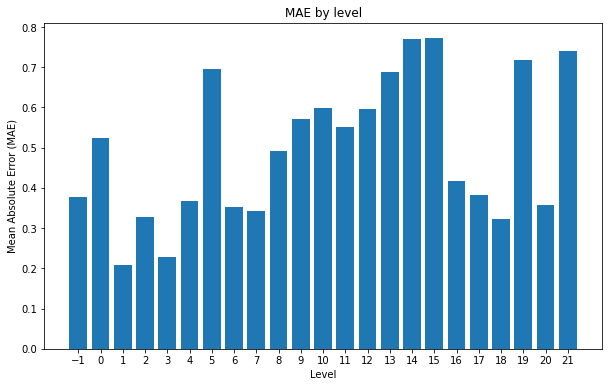

In [99]:
plot_mae_by_level(y_test, y_pred_test)

In [100]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.52
RMSE: 0.72



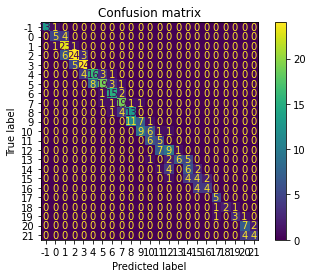

In [101]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [102]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.340495	valid_0's l2: 0.243018


In [103]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [105]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

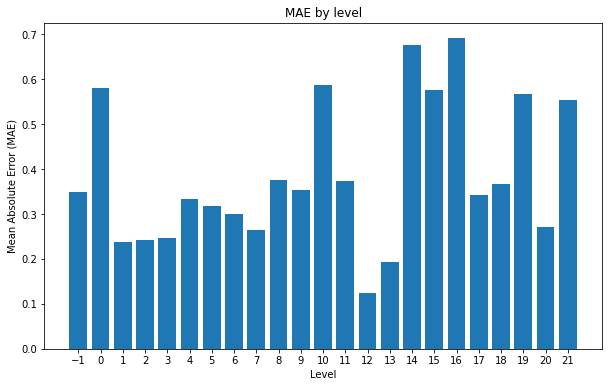

In [106]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [107]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



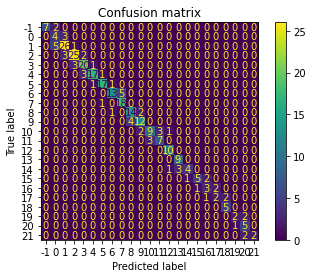

In [108]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [109]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:27:21,006] A new study created in memory with name: no-name-34d1366f-5233-4b83-a88b-f5f69a0ab484

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.258042 + 0.0766333
[200]	cv_agg's l2: 0.260551 + 0.0773974



feature_fraction, val_score: 0.256473:  14%|######4                                      | 1/7 [00:03<00:22,  3.70s/it][I 2023-11-03 20:27:24,717] Trial 0 finished with value: 0.25647278636505055 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.25647278636505055.

feature_fraction, val_score: 0.256473:  14%|######4                                      | 1/7 [00:03<00:22,  3.70s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.256473 + 0.0774793
[100]	cv_agg's l2: 0.252087 + 0.0449266


[200]	cv_agg's l2: 0.251471 + 0.0429625
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.249067 + 0.0451603


feature_fraction, val_score: 0.249067:  29%|############8                                | 2/7 [00:05<00:13,  2.77s/it][I 2023-11-03 20:27:26,839] Trial 1 finished with value: 0.24906707909060835 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.24906707909060835.

feature_fraction, val_score: 0.249067:  29%|############8                                | 2/7 [00:05<00:13,  2.77s/it]

[100]	cv_agg's l2: 0.392067 + 0.0460744


[200]	cv_agg's l2: 0.345326 + 0.0461259
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.249067 + 0.0451603


feature_fraction, val_score: 0.249067:  43%|###################2                         | 3/7 [00:08<00:10,  2.53s/it][I 2023-11-03 20:27:29,073] Trial 2 finished with value: 0.3801583835630383 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.24906707909060835.

feature_fraction, val_score: 0.249067:  43%|###################2                         | 3/7 [00:08<00:10,  2.53s/it]

[100]	cv_agg's l2: 0.260748 + 0.037713
[200]	cv_agg's l2: 0.256673 + 0.0366897



feature_fraction, val_score: 0.249067:  57%|#########################7                   | 4/7 [00:10<00:07,  2.51s/it][I 2023-11-03 20:27:31,554] Trial 3 finished with value: 0.2579190933744858 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.24906707909060835.

feature_fraction, val_score: 0.249067:  57%|#########################7                   | 4/7 [00:10<00:07,  2.51s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.249067 + 0.0451603
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



feature_fraction, val_score: 0.243619:  71%|################################1            | 5/7 [00:13<00:05,  2.52s/it][I 2023-11-03 20:27:34,097] Trial 4 finished with value: 0.24361919309085622 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.24361919309085622.

feature_fraction, val_score: 0.243619:  71%|################################1            | 5/7 [00:13<00:05,  2.52s/it]

[100]	cv_agg's l2: 0.252035 + 0.0744008



feature_fraction, val_score: 0.243619:  86%|######################################5      | 6/7 [00:15<00:02,  2.46s/it][I 2023-11-03 20:27:36,450] Trial 5 finished with value: 0.2513127321489727 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 0.24361919309085622.


[200]	cv_agg's l2: 0.252855 + 0.0684394
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



feature_fraction, val_score: 0.243619:  86%|######################################5      | 6/7 [00:15<00:02,  2.46s/it]

[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



feature_fraction, val_score: 0.243619: 100%|#############################################| 7/7 [00:18<00:00,  2.59s/it]

num_leaves, val_score: 0.243619:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:   5%|##5                                               | 1/20 [00:02<00:50,  2.67s/it][I 2023-11-03 20:27:41,864] Trial 7 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 203}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:   5%|##5                                               | 1/20 [00:02<00:50,  2.67s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.249168 + 0.0682627



num_leaves, val_score: 0.243619:  10%|#####                                             | 2/20 [00:03<00:32,  1.81s/it][I 2023-11-03 20:27:43,070] Trial 8 finished with value: 0.24697710011434637 and parameters: {'num_leaves': 10}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  10%|#####                                             | 2/20 [00:03<00:32,  1.81s/it]

[200]	cv_agg's l2: 0.244383 + 0.0622247
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



num_leaves, val_score: 0.243619:  15%|#######5                                          | 3/20 [00:06<00:33,  1.99s/it][I 2023-11-03 20:27:45,267] Trial 9 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 193}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  15%|#######5                                          | 3/20 [00:06<00:33,  1.99s/it]

[100]	cv_agg's l2: 0.245756 + 0.0501741



num_leaves, val_score: 0.243619:  20%|##########                                        | 4/20 [00:08<00:32,  2.06s/it][I 2023-11-03 20:27:47,436] Trial 10 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 44}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  20%|##########                                        | 4/20 [00:08<00:32,  2.06s/it]

[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  25%|############5                                     | 5/20 [00:10<00:31,  2.07s/it][I 2023-11-03 20:27:49,526] Trial 11 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 111}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  25%|############5                                     | 5/20 [00:10<00:31,  2.07s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741



num_leaves, val_score: 0.243619:  30%|###############                                   | 6/20 [00:12<00:30,  2.17s/it][I 2023-11-03 20:27:51,876] Trial 12 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  30%|###############                                   | 6/20 [00:12<00:30,  2.17s/it]

[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  35%|#################5                                | 7/20 [00:15<00:29,  2.26s/it][I 2023-11-03 20:27:54,343] Trial 13 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 100}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  35%|#################5                                | 7/20 [00:15<00:29,  2.26s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  40%|####################                              | 8/20 [00:17<00:28,  2.38s/it][I 2023-11-03 20:27:56,969] Trial 14 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  40%|####################                              | 8/20 [00:17<00:28,  2.38s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741


[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284


num_leaves, val_score: 0.243619:  45%|######################5                           | 9/20 [00:20<00:28,  2.57s/it][I 2023-11-03 20:27:59,959] Trial 15 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  45%|######################5                           | 9/20 [00:20<00:28,  2.57s/it]

[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  50%|########################5                        | 10/20 [00:23<00:25,  2.59s/it][I 2023-11-03 20:28:02,606] Trial 16 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 241}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  50%|########################5                        | 10/20 [00:23<00:25,  2.59s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741



num_leaves, val_score: 0.243619:  55%|##########################9                      | 11/20 [00:25<00:22,  2.49s/it]

[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284


[I 2023-11-03 20:28:04,877] Trial 17 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 144}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  55%|##########################9                      | 11/20 [00:25<00:22,  2.49s/it]

[100]	cv_agg's l2: 0.281566 + 0.0668137



num_leaves, val_score: 0.243619:  60%|#############################4                   | 12/20 [00:26<00:15,  1.89s/it][I 2023-11-03 20:28:05,378] Trial 18 finished with value: 0.2746698634397414 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  60%|#############################4                   | 12/20 [00:26<00:15,  1.89s/it]

[200]	cv_agg's l2: 0.262697 + 0.0628609
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741



num_leaves, val_score: 0.243619:  65%|###############################8                 | 13/20 [00:28<00:13,  1.94s/it][I 2023-11-03 20:28:07,448] Trial 19 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 78}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  65%|###############################8                 | 13/20 [00:28<00:13,  1.94s/it]

[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741



num_leaves, val_score: 0.243619:  65%|###############################8                 | 13/20 [00:30<00:13,  1.94s/it]

[200]	cv_agg's l2: 0.247728 + 0.0476141
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



num_leaves, val_score: 0.243619:  70%|##################################3              | 14/20 [00:30<00:12,  2.02s/it][I 2023-11-03 20:28:09,646] Trial 20 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 142}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  70%|##################################3              | 14/20 [00:30<00:12,  2.02s/it]

[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  75%|####################################7            | 15/20 [00:32<00:10,  2.15s/it][I 2023-11-03 20:28:12,110] Trial 21 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  75%|####################################7            | 15/20 [00:32<00:10,  2.15s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  80%|#######################################2         | 16/20 [00:35<00:08,  2.24s/it][I 2023-11-03 20:28:14,536] Trial 22 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 196}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  80%|#######################################2         | 16/20 [00:35<00:08,  2.24s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  85%|#########################################6       | 17/20 [00:37<00:06,  2.26s/it][I 2023-11-03 20:28:16,861] Trial 23 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  85%|#########################################6       | 17/20 [00:37<00:06,  2.26s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  90%|############################################1    | 18/20 [00:39<00:04,  2.28s/it][I 2023-11-03 20:28:19,182] Trial 24 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  90%|############################################1    | 18/20 [00:39<00:04,  2.28s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619:  95%|##############################################5  | 19/20 [00:42<00:02,  2.35s/it][I 2023-11-03 20:28:21,688] Trial 25 finished with value: 0.24361919309085622 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 0.24361919309085622.

num_leaves, val_score: 0.243619:  95%|##############################################5  | 19/20 [00:42<00:02,  2.35s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.245756 + 0.0501741
[200]	cv_agg's l2: 0.247728 + 0.0476141



num_leaves, val_score: 0.243619: 100%|#################################################| 20/20 [00:44<00:00,  2.24s/it]


Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284



bagging, val_score: 0.243619:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.297568 + 0.0481545



bagging, val_score: 0.243619:  10%|#####3                                               | 1/10 [00:01<00:13,  1.50s/it][I 2023-11-03 20:28:25,537] Trial 27 finished with value: 0.2917468586931931 and parameters: {'bagging_fraction': 0.4948877585019132, 'bagging_freq': 5}. Best is trial 27 with value: 0.2917468586931931.

bagging, val_score: 0.243619:  10%|#####3                                               | 1/10 [00:01<00:13,  1.50s/it]

[200]	cv_agg's l2: 0.285319 + 0.0482358
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.243619 + 0.0487284
[100]	cv_agg's l2: 0.246498 + 0.0542939
[200]	cv_agg's l2: 0.243968 + 0.0506084



bagging, val_score: 0.243060:  20%|##########6                                          | 2/10 [00:04<00:19,  2.42s/it][I 2023-11-03 20:28:28,601] Trial 28 finished with value: 0.24306014084407757 and parameters: {'bagging_fraction': 0.9967776435758241, 'bagging_freq': 1}. Best is trial 28 with value: 0.24306014084407757.

bagging, val_score: 0.243060:  20%|##########6                                          | 2/10 [00:04<00:19,  2.42s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.24306 + 0.0516623
[100]	cv_agg's l2: 0.246311 + 0.0519815
[200]	cv_agg's l2: 0.246746 + 0.0478371



bagging, val_score: 0.243060:  30%|###############9                                     | 3/10 [00:07<00:19,  2.75s/it][I 2023-11-03 20:28:31,734] Trial 29 finished with value: 0.24596177678583997 and parameters: {'bagging_fraction': 0.9857615831620351, 'bagging_freq': 1}. Best is trial 28 with value: 0.24306014084407757.

bagging, val_score: 0.243060:  30%|###############9                                     | 3/10 [00:07<00:19,  2.75s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.24306 + 0.0516623
[100]	cv_agg's l2: 0.241714 + 0.0514664
[200]	cv_agg's l2: 0.242178 + 0.0469376



bagging, val_score: 0.240454:  40%|#####################2                               | 4/10 [00:10<00:16,  2.70s/it][I 2023-11-03 20:28:34,351] Trial 30 finished with value: 0.2404544020727352 and parameters: {'bagging_fraction': 0.9953695683942871, 'bagging_freq': 1}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  40%|#####################2                               | 4/10 [00:10<00:16,  2.70s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.246289 + 0.0535589
[200]	cv_agg's l2: 0.245555 + 0.0504801



bagging, val_score: 0.240454:  50%|##########################5                          | 5/10 [00:12<00:12,  2.59s/it][I 2023-11-03 20:28:36,758] Trial 31 finished with value: 0.2449550874590846 and parameters: {'bagging_fraction': 0.9970000598173518, 'bagging_freq': 1}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  50%|##########################5                          | 5/10 [00:12<00:12,  2.59s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.24856 + 0.0469274
[200]	cv_agg's l2: 0.245753 + 0.0369153



bagging, val_score: 0.240454:  60%|###############################8                     | 6/10 [00:14<00:09,  2.46s/it][I 2023-11-03 20:28:38,955] Trial 32 finished with value: 0.24681027584645018 and parameters: {'bagging_fraction': 0.8786377410292137, 'bagging_freq': 2}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  60%|###############################8                     | 6/10 [00:14<00:09,  2.46s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.253583 + 0.0502042
[200]	cv_agg's l2: 0.253265 + 0.0434476



bagging, val_score: 0.240454:  70%|#####################################                | 7/10 [00:16<00:06,  2.27s/it][I 2023-11-03 20:28:40,854] Trial 33 finished with value: 0.2524164694265854 and parameters: {'bagging_fraction': 0.8019447334843378, 'bagging_freq': 3}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  70%|#####################################                | 7/10 [00:16<00:06,  2.27s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.250481 + 0.0475338


[200]	cv_agg's l2: 0.246089 + 0.0429463
Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262


bagging, val_score: 0.240454:  80%|##########################################4          | 8/10 [00:18<00:04,  2.21s/it][I 2023-11-03 20:28:42,935] Trial 34 finished with value: 0.24924718320335976 and parameters: {'bagging_fraction': 0.774242052218528, 'bagging_freq': 7}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  80%|##########################################4          | 8/10 [00:18<00:04,  2.21s/it]

[100]	cv_agg's l2: 0.248321 + 0.057961
[200]	cv_agg's l2: 0.249831 + 0.051973



bagging, val_score: 0.240454:  90%|###############################################7     | 9/10 [00:21<00:02,  2.42s/it][I 2023-11-03 20:28:45,824] Trial 35 finished with value: 0.24882634366277362 and parameters: {'bagging_fraction': 0.9714768219016312, 'bagging_freq': 4}. Best is trial 30 with value: 0.2404544020727352.

bagging, val_score: 0.240454:  90%|###############################################7     | 9/10 [00:21<00:02,  2.42s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.263272 + 0.0488822
[200]	cv_agg's l2: 0.257649 + 0.0490558



bagging, val_score: 0.240454: 100%|####################################################| 10/10 [00:23<00:00,  2.39s/it]


Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262



feature_fraction_stage2, val_score: 0.240454:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.241714 + 0.0514664
[200]	cv_agg's l2: 0.242178 + 0.0469376



feature_fraction_stage2, val_score: 0.240454:  17%|######3                               | 1/6 [00:02<00:11,  2.23s/it][I 2023-11-03 20:28:50,199] Trial 37 finished with value: 0.2404544020727352 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.2404544020727352.

feature_fraction_stage2, val_score: 0.240454:  17%|######3                               | 1/6 [00:02<00:11,  2.23s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.251861 + 0.0725812
[200]	cv_agg's l2: 0.256589 + 0.0687553



feature_fraction_stage2, val_score: 0.240454:  33%|############6                         | 2/6 [00:05<00:10,  2.73s/it][I 2023-11-03 20:28:53,276] Trial 38 finished with value: 0.2535859162752702 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.2404544020727352.

feature_fraction_stage2, val_score: 0.240454:  33%|############6                         | 2/6 [00:05<00:10,  2.73s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.241714 + 0.0514664
[200]	cv_agg's l2: 0.242178 + 0.0469376



feature_fraction_stage2, val_score: 0.240454:  50%|###################                   | 3/6 [00:07<00:07,  2.54s/it][I 2023-11-03 20:28:55,596] Trial 39 finished with value: 0.2404544020727352 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.2404544020727352.

feature_fraction_stage2, val_score: 0.240454:  50%|###################                   | 3/6 [00:07<00:07,  2.54s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.251861 + 0.0725812
[200]	cv_agg's l2: 0.256589 + 0.0687553



feature_fraction_stage2, val_score: 0.240454:  67%|#########################3            | 4/6 [00:09<00:04,  2.36s/it][I 2023-11-03 20:28:57,684] Trial 40 finished with value: 0.2535859162752702 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.2404544020727352.

feature_fraction_stage2, val_score: 0.240454:  67%|#########################3            | 4/6 [00:09<00:04,  2.36s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.241714 + 0.0514664
[200]	cv_agg's l2: 0.242178 + 0.0469376



feature_fraction_stage2, val_score: 0.240454:  83%|###############################6      | 5/6 [00:11<00:02,  2.31s/it][I 2023-11-03 20:28:59,910] Trial 41 finished with value: 0.2404544020727352 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.2404544020727352.

feature_fraction_stage2, val_score: 0.240454:  83%|###############################6      | 5/6 [00:11<00:02,  2.31s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262
[100]	cv_agg's l2: 0.251861 + 0.0725812
[200]	cv_agg's l2: 0.256589 + 0.0687553



feature_fraction_stage2, val_score: 0.240454: 100%|######################################| 6/6 [00:14<00:00,  2.38s/it]


Early stopping, best iteration is:
[131]	cv_agg's l2: 0.240454 + 0.0486262



regularization_factors, val_score: 0.240454:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:   5%|#9                                    | 1/20 [00:02<00:40,  2.14s/it][I 2023-11-03 20:29:04,373] Trial 43 finished with value: 0.2395624236129709 and parameters: {'lambda_l1': 4.1525431771314034e-07, 'lambda_l2': 5.0292195544668144e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:   5%|#9                                    | 1/20 [00:02<00:40,  2.14s/it]

[200]	cv_agg's l2: 0.240516 + 0.0448429
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  10%|###8                                  | 2/20 [00:04<00:44,  2.45s/it][I 2023-11-03 20:29:07,035] Trial 44 finished with value: 0.23956245242343419 and parameters: {'lambda_l1': 1.7507514734556822e-07, 'lambda_l2': 2.290054424135494e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  10%|###8                                  | 2/20 [00:04<00:44,  2.45s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  15%|#####7                                | 3/20 [00:07<00:41,  2.41s/it][I 2023-11-03 20:29:09,409] Trial 45 finished with value: 0.2395624483811773 and parameters: {'lambda_l1': 1.868890477238193e-07, 'lambda_l2': 2.6613828309349337e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  15%|#####7                                | 3/20 [00:07<00:41,  2.41s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  20%|#######6                              | 4/20 [00:09<00:37,  2.34s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118


[I 2023-11-03 20:29:11,643] Trial 46 finished with value: 0.2395624459346915 and parameters: {'lambda_l1': 1.1891048114684737e-07, 'lambda_l2': 2.9329528631726558e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  20%|#######6                              | 4/20 [00:09<00:37,  2.34s/it]

[100]	cv_agg's l2: 0.239848 + 0.0481639
[200]	cv_agg's l2: 0.240844 + 0.0445206



regularization_factors, val_score: 0.239562:  25%|#########5                            | 5/20 [00:12<00:36,  2.44s/it][I 2023-11-03 20:29:14,264] Trial 47 finished with value: 0.23956245749588287 and parameters: {'lambda_l1': 1.3374014848001607e-07, 'lambda_l2': 1.7689322473559804e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  25%|#########5                            | 5/20 [00:12<00:36,  2.44s/it]

Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  30%|###########4                          | 6/20 [00:14<00:34,  2.48s/it][I 2023-11-03 20:29:16,814] Trial 48 finished with value: 0.2395624481327415 and parameters: {'lambda_l1': 1.3666602924174811e-07, 'lambda_l2': 2.7096848093668172e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  30%|###########4                          | 6/20 [00:14<00:34,  2.48s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  35%|#############3                        | 7/20 [00:16<00:31,  2.41s/it][I 2023-11-03 20:29:19,092] Trial 49 finished with value: 0.23956244240505448 and parameters: {'lambda_l1': 1.5019460513164983e-07, 'lambda_l2': 3.297306675392506e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  35%|#############3                        | 7/20 [00:16<00:31,  2.41s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  40%|###############2                      | 8/20 [00:19<00:28,  2.35s/it][I 2023-11-03 20:29:21,314] Trial 50 finished with value: 0.23956242893888957 and parameters: {'lambda_l1': 1.3622370012054188e-07, 'lambda_l2': 4.5216112532411356e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  40%|###############2                      | 8/20 [00:19<00:28,  2.35s/it]

[200]	cv_agg's l2: 0.240516 + 0.0448429
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  45%|#################1                    | 9/20 [00:21<00:24,  2.26s/it][I 2023-11-03 20:29:23,368] Trial 51 finished with value: 0.23956244239028734 and parameters: {'lambda_l1': 1.2698651562977602e-07, 'lambda_l2': 3.2248517541671025e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  45%|#################1                    | 9/20 [00:21<00:24,  2.26s/it]

[200]	cv_agg's l2: 0.240844 + 0.0445206
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  50%|##################5                  | 10/20 [00:23<00:22,  2.26s/it][I 2023-11-03 20:29:25,626] Trial 52 finished with value: 0.23956242462070437 and parameters: {'lambda_l1': 1.2058046951405968e-07, 'lambda_l2': 4.961388281026537e-05}. Best is trial 43 with value: 0.2395624236129709.

regularization_factors, val_score: 0.239562:  50%|##################5                  | 10/20 [00:23<00:22,  2.26s/it]

[200]	cv_agg's l2: 0.240516 + 0.0448429
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.239848 + 0.0481639



regularization_factors, val_score: 0.239562:  55%|####################3                | 11/20 [00:25<00:19,  2.20s/it][I 2023-11-03 20:29:27,704] Trial 53 finished with value: 0.2395624183887048 and parameters: {'lambda_l1': 1.1610442310149419e-07, 'lambda_l2': 5.533273741220775e-05}. Best is trial 53 with value: 0.2395624183887048.

regularization_factors, val_score: 0.239562:  55%|####################3                | 11/20 [00:25<00:19,  2.20s/it]

[200]	cv_agg's l2: 0.240516 + 0.0448429
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.241091 + 0.0510662



regularization_factors, val_score: 0.239562:  60%|######################2              | 12/20 [00:27<00:17,  2.16s/it][I 2023-11-03 20:29:29,758] Trial 54 finished with value: 0.24097423410715096 and parameters: {'lambda_l1': 1.1496894341714792e-07, 'lambda_l2': 0.00015471506981329117}. Best is trial 53 with value: 0.2395624183887048.

regularization_factors, val_score: 0.239562:  60%|######################2              | 12/20 [00:27<00:17,  2.16s/it]

[200]	cv_agg's l2: 0.242444 + 0.0476949
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.241091 + 0.0510662



regularization_factors, val_score: 0.239562:  65%|########################             | 13/20 [00:29<00:14,  2.13s/it][I 2023-11-03 20:29:31,811] Trial 55 finished with value: 0.24097414288145086 and parameters: {'lambda_l1': 1.0999431112739969e-07, 'lambda_l2': 0.0002500696625084365}. Best is trial 53 with value: 0.2395624183887048.

regularization_factors, val_score: 0.239562:  65%|########################             | 13/20 [00:29<00:14,  2.13s/it]

[200]	cv_agg's l2: 0.242443 + 0.047695
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.239562 + 0.0465118
[100]	cv_agg's l2: 0.23966 + 0.0476445


[200]	cv_agg's l2: 0.241287 + 0.0446516
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021


regularization_factors, val_score: 0.239054:  70%|#########################9           | 14/20 [00:31<00:13,  2.20s/it][I 2023-11-03 20:29:34,172] Trial 56 finished with value: 0.23905363955556078 and parameters: {'lambda_l1': 2.219020641512848e-05, 'lambda_l2': 5.8988913035239524e-08}. Best is trial 56 with value: 0.23905363955556078.

regularization_factors, val_score: 0.239054:  70%|#########################9           | 14/20 [00:31<00:13,  2.20s/it]

[100]	cv_agg's l2: 0.23966 + 0.0476445
[200]	cv_agg's l2: 0.241287 + 0.0446516



regularization_factors, val_score: 0.239054:  75%|###########################7         | 15/20 [00:34<00:11,  2.27s/it][I 2023-11-03 20:29:36,629] Trial 57 finished with value: 0.2390536379038189 and parameters: {'lambda_l1': 2.389896623246262e-05, 'lambda_l2': 8.653117985301085e-08}. Best is trial 57 with value: 0.2390536379038189.

regularization_factors, val_score: 0.239054:  75%|###########################7         | 15/20 [00:34<00:11,  2.27s/it]

Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.23948 + 0.0478337
[200]	cv_agg's l2: 0.241843 + 0.0441193



regularization_factors, val_score: 0.239054:  80%|#############################6       | 16/20 [00:36<00:09,  2.29s/it][I 2023-11-03 20:29:38,963] Trial 58 finished with value: 0.2392137576924438 and parameters: {'lambda_l1': 1.3856965227798717e-05, 'lambda_l2': 3.1941782475864307e-08}. Best is trial 57 with value: 0.2390536379038189.

regularization_factors, val_score: 0.239054:  80%|#############################6       | 16/20 [00:36<00:09,  2.29s/it]

Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.23966 + 0.0476445
[200]	cv_agg's l2: 0.241287 + 0.0446515



regularization_factors, val_score: 0.239054:  85%|###############################4     | 17/20 [00:39<00:07,  2.46s/it][I 2023-11-03 20:29:41,820] Trial 59 finished with value: 0.23905364145750005 and parameters: {'lambda_l1': 1.9974133577403294e-05, 'lambda_l2': 3.725558039564673e-08}. Best is trial 57 with value: 0.2390536379038189.

regularization_factors, val_score: 0.239054:  85%|###############################4     | 17/20 [00:39<00:07,  2.46s/it]

Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.23966 + 0.0476445



regularization_factors, val_score: 0.239054:  90%|#################################3   | 18/20 [00:42<00:04,  2.48s/it][I 2023-11-03 20:29:44,351] Trial 60 finished with value: 0.23905363599800414 and parameters: {'lambda_l1': 2.6740190909219915e-05, 'lambda_l2': 3.593499555306782e-08}. Best is trial 60 with value: 0.23905363599800414.

regularization_factors, val_score: 0.239054:  90%|#################################3   | 18/20 [00:42<00:04,  2.48s/it]

[200]	cv_agg's l2: 0.241287 + 0.0446516
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.23966 + 0.0476445



regularization_factors, val_score: 0.239054:  95%|###################################1 | 19/20 [00:44<00:02,  2.45s/it]

[200]	cv_agg's l2: 0.241287 + 0.0446516
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021


[I 2023-11-03 20:29:46,735] Trial 61 finished with value: 0.23905363494165116 and parameters: {'lambda_l1': 2.7567146575788472e-05, 'lambda_l2': 3.9151314467875654e-08}. Best is trial 61 with value: 0.23905363494165116.

regularization_factors, val_score: 0.239054:  95%|###################################1 | 19/20 [00:44<00:02,  2.45s/it]

[100]	cv_agg's l2: 0.23966 + 0.0476445
[200]	cv_agg's l2: 0.241287 + 0.0446516



regularization_factors, val_score: 0.239054: 100%|#####################################| 20/20 [00:47<00:00,  2.36s/it]


Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021



min_data_in_leaf, val_score: 0.239054:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244028 + 0.0437999



min_data_in_leaf, val_score: 0.239054:  20%|#########                                    | 1/5 [00:03<00:12,  3.11s/it][I 2023-11-03 20:29:52,598] Trial 63 finished with value: 0.24538823902973506 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.24538823902973506.

min_data_in_leaf, val_score: 0.239054:  20%|#########                                    | 1/5 [00:03<00:12,  3.11s/it]

[200]	cv_agg's l2: 0.246648 + 0.0438137
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.329369 + 0.0719615



min_data_in_leaf, val_score: 0.239054:  40%|##################                           | 2/5 [00:04<00:06,  2.28s/it][I 2023-11-03 20:29:54,296] Trial 64 finished with value: 0.32819872937417494 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.24538823902973506.

min_data_in_leaf, val_score: 0.239054:  40%|##################                           | 2/5 [00:04<00:06,  2.28s/it]

[200]	cv_agg's l2: 0.327534 + 0.0648785
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.824413 + 0.0787284



min_data_in_leaf, val_score: 0.239054:  60%|###########################                  | 3/5 [00:05<00:03,  1.58s/it][I 2023-11-03 20:29:55,044] Trial 65 finished with value: 0.8217533430149091 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.24538823902973506.

min_data_in_leaf, val_score: 0.239054:  60%|###########################                  | 3/5 [00:05<00:03,  1.58s/it]

[200]	cv_agg's l2: 0.804277 + 0.0899831
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.266815 + 0.0633354



min_data_in_leaf, val_score: 0.239054:  80%|####################################         | 4/5 [00:07<00:01,  1.76s/it][I 2023-11-03 20:29:57,079] Trial 66 finished with value: 0.2654710510690165 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.24538823902973506.

min_data_in_leaf, val_score: 0.239054:  80%|####################################         | 4/5 [00:07<00:01,  1.76s/it]

[200]	cv_agg's l2: 0.265878 + 0.0587652
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021
[100]	cv_agg's l2: 0.243755 + 0.0506204


[200]	cv_agg's l2: 0.24747 + 0.0499737
Early stopping, best iteration is:
[118]	cv_agg's l2: 0.239054 + 0.0466021


min_data_in_leaf, val_score: 0.239054: 100%|#############################################| 5/5 [00:10<00:00,  2.00s/it]


In [110]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.23905363204411983
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 3.082837585590232e-05
    lambda_l2: 3.658442806012557e-08
    num_leaves: 31
    feature_fraction: 0.8
    bagging_fraction: 0.9953695683942871
    bagging_freq: 1
    min_child_samples: 20


In [111]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [112]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.53
MSE test: 0.28
MAE test: 0.35



In [113]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

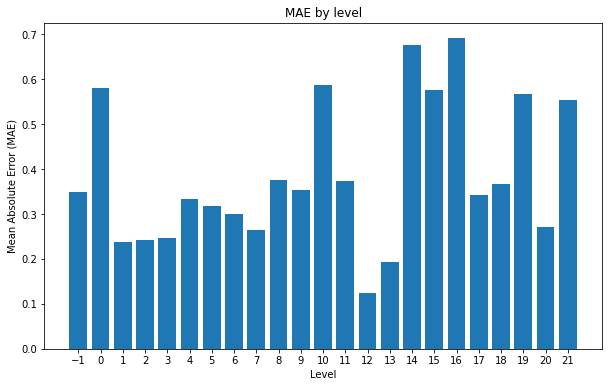

In [114]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [115]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.12
RMSE: 0.35

Round type: round
MSE: 0.13
RMSE: 0.36

Round type: 0.33
MSE: 0.16
RMSE: 0.40

Round type: 0.45
MSE: 0.14
RMSE: 0.37



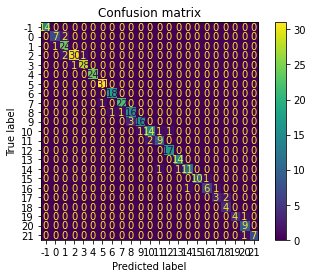

In [116]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [117]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.447566,0.669004,0.467604
1,chronological,Optuna,8,0.450794,0.671412,0.475812
2,random,normal,8,0.243018,0.492968,0.340495
3,random,Optuna,8,0.279737,0.528901,0.354820


In [118]:
from training.results import plot_summary

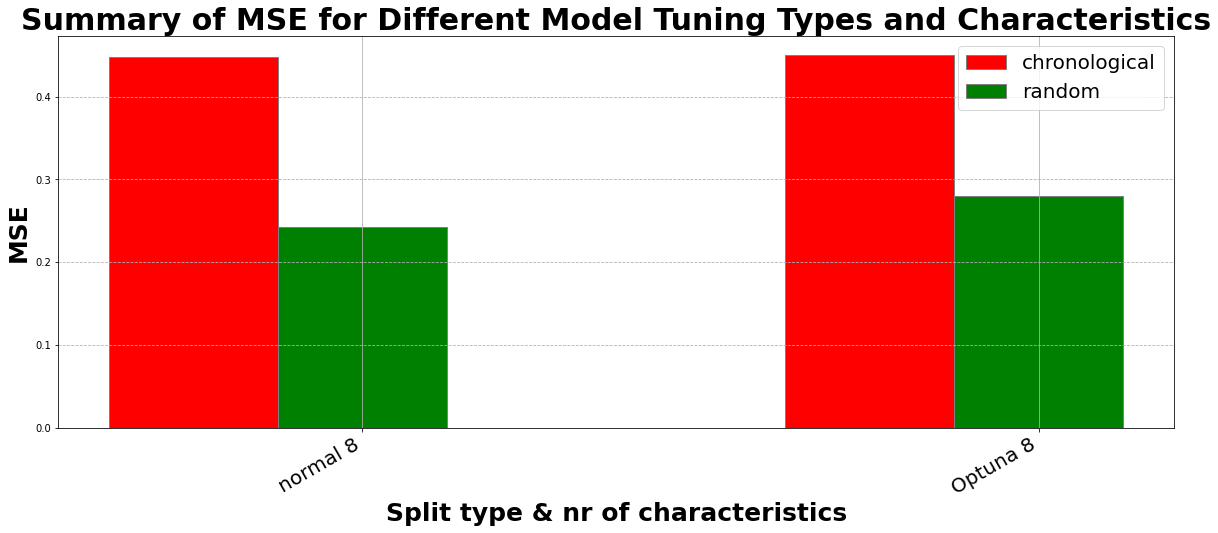

In [119]:
plot_summary(results, "MSE")

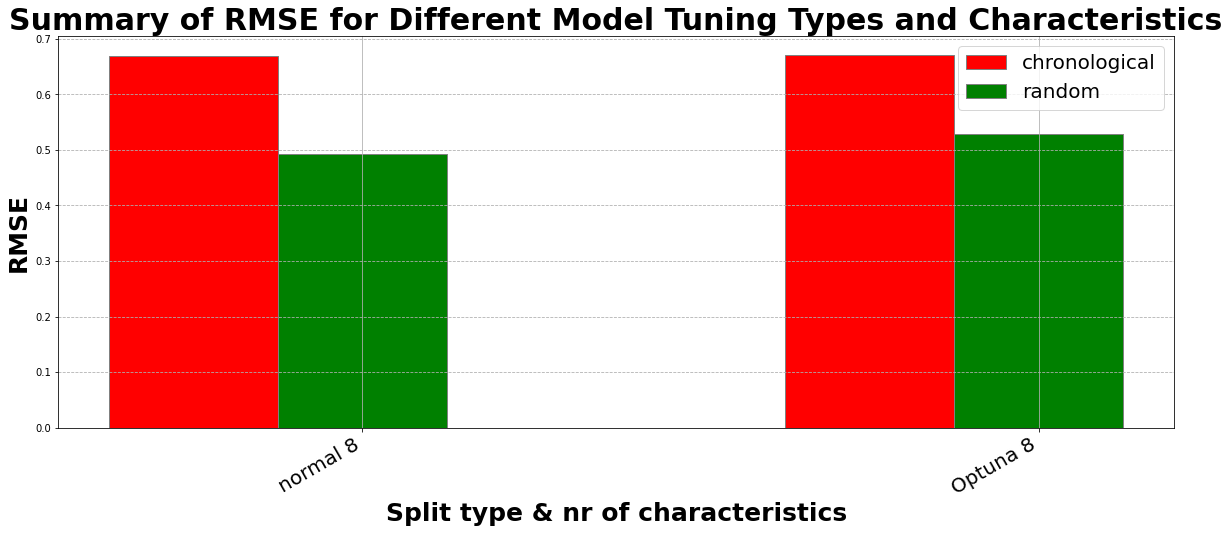

In [120]:
plot_summary(results, "RMSE")

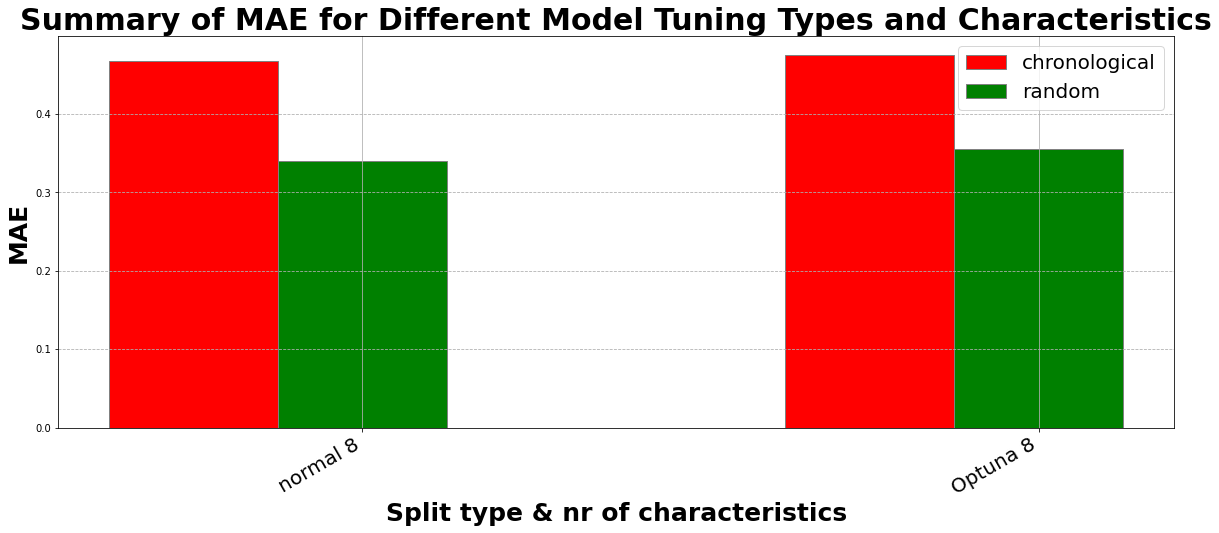

In [121]:
plot_summary(results, "MAE")

In [122]:
results.to_json("./lightgbm_basic_results.json")